**Author** Kelsey Beckrich

# Unsupervised Endmember Extraction from NEON Hyperspectral Tile
<p> The following workflow is the basis for Keadapts the National Ecological Observatory Network's (NEON)<a href = "https://www.neonscience.org/classification-endmember-python" target ="blank" > Unsupervised Endmember Extraction </a>  tutorial to a site near the Onaqui Mountains of Utah. While we have used this workflow to extract the endmembers from sagebrush ecosystems using both  NEON's hyperspectral mosaicked flightlines and LANDSAT's multispectral satellite images, this workflow is exclusively for hyperspectral data. The multispectral portion of this analysis can be found on Sarah Jaffe's <a href="https://github.com/sarahmjaffe/sagebrush-ecosystem-modeling-with-landsat8/" target="blank" > Sagebrush Ecosystem Modeling with Landsat 8 </a> github repository. </p>
    

# Imports

In [1]:
from glob import glob
import h5py, os, copy
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats.stats import pearsonr
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pandas as pd
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
from earthpy.spatial import bytescale
import sys

from neon_helper_functions import *

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Import Hyperspectral

NEON creates hyperspectral data which is available in both flightlines and mosaicked tiles of those flightlines which are roughly 1.4GB and 0.6GB per file, respectively. Since these files are large, they are time intensive to download and analyze, and the RAM required to work with the flightlines exceeded what my computer could handle without significantly subsetting by bands or cropping the extent. Consequently, this workflow uses only the tiled data which is available from NEON <a href ="https://data.neonscience.org/data-products/DP3.30006.001" target= "blank" > here</a>. The specific tiles used in this workflow are publicly hosted on my <a href ="https://figshare.com/articles/dataset/NEON_Hyperspectral_Tiles/12584957" target ="blank" >figshare</a> to ensure workflow reproducibility. While this workflow is scalable and has been tested with multiple tiles from NEON's  <a href="https://www.neonscience.org/field-sites/field-sites-map/ONAQ" target="_blank">ONAQ</a> site in Utah, this workflow only processes tile 378000_4452000. I have left the figshare download for 374000_4449000 in the downloads cell below for future analysis, but it is commented out to reduce processing time since it is not essential for this workflow.

In [5]:
# Imports tile 374000_4449000
#et.data.get_data(url='https://ndownloader.figshare.com/files/23535881')
# Imports tile 378000_4452000
et.data.get_data(url='https://ndownloader.figshare.com/files/23535953')

'C:\\Users\\17205\\earth-analytics\\data\\earthpy-downloads\\NEON_D15_ONAQ_DP3_378000_4452000_reflectance.h5'

In [7]:
# Import hyp data into dict with tile number as key

ONAQ_hyp_refl=glob(os.path.join('data','earthpy-downloads','*DP3*'))

# File import is scalable if multiple tiles are available
ONAQ_data={}
for file in ONAQ_hyp_refl:
    data,metadata=read_neon_reflh5(file)
    data_clean,metadata_clean = clean_neon_refl_data(
    data,metadata)
    print('Tile Key:',os.path.basename(file)[18:32])
    ONAQ_data[os.path.basename(file)[18:32]]={
        'reflectance':data_clean,
        'metadata':metadata_clean}
print('Raw Data Dimensions:',data.shape)
print('Cleaned Data Dimensions:',data_clean.shape)

Tile Key: 374000_4449000
Tile Key: 378000_4452000
Raw Data Dimensions: (1000, 1000, 426)
Cleaned Data Dimensions: (1000, 1000, 360)


# Import spectral signature

Spectral signatures for our focal species, Greater Sagebrush and Cheatgrass, were downloaded from the USGS's <a href = "https://crustal.usgs.gov/speclab/" target= "blank" > Spectral Library </a> and are hosted on <a href ="https://figshare.com/authors/Sarah_Jaffe/8848913" target ="blank" > Sarah Jaffe's figshare </a> for reproducibilty. We used the Spectral Library's Convolved to Terrestrial Spectrometers of AVIRIS 2014 as a "pure" spectral signature to which I compared the NEON hyperspectral data. While the AVIRIS and NEON spectra are both hyperspectral products and cover roughly the same span of wavelengths, the NEON data is higher resolution. Therefore, the spectral curves from the library had 224 bands while the spectral curves from NEON had 426 bands (360 after cleaning). Consequently, the spectral library data had to be interpolated to 360 bands to ensure statistical comparison between the spectral library "pure" signatures and the spectral signatures extracted from the NEON tile.

In [8]:
# Download data hosted on figshare
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262782')
et.data.get_data(
    url='https://ndownloader.figshare.com/files/23262785')


'C:\\Users\\17205\\earth-analytics\\data\\earthpy-downloads\\s07_AV14_Cheatgrass_ANP92-11A_BECKa_AREF'

In [10]:
# Create list of directories to spectral signatures
AV_spect_lib_dir=glob(os.path.join('data','earthpy-downloads','*AV14*'))
AV_spect_sig={}
# Remove unnecessary files, import reflectance and wavelength as arrays
for dirs in AV_spect_lib_dir:
    error_bar=sorted(glob(os.path.join(dirs,'*errorbar*')))
    resolution_file=sorted(glob(os.path.join(dirs,'*Resolution*')))
    if not len(error_bar) == 0:
        os.remove(error_bar[0])
    if not len(resolution_file) == 0:
        os.remove(resolution_file[0])
    txt_files=sorted(glob(os.path.join(dirs,'*txt*')))
    # Use vegetation type name from file path as dict key
    object_name=os.path.basename(txt_files[0]).split('_')[2]
    AV_spect_sig[object_name]= {
        'Resolution':np.loadtxt(txt_files[0],skiprows=1),
        'Wavelength':np.loadtxt(txt_files[1],skiprows=1)}
# Print available signatures for users
for key in AV_spect_sig.keys():
    print('Spectral signatures available for', key)

Spectral signatures available for Cheatgrass
Spectral signatures available for Sagebrush


In [12]:
# Clean spectral library bad reflectance values
cheatgrass_res,cheatgrass_wave=clean_spectral_array(
    object_spect_dict=AV_spect_sig['Cheatgrass'])
sagebrush_res,sagebrush_wave=clean_spectral_array(
    object_spect_dict=AV_spect_sig['Sagebrush'])

In [13]:
# Interpolate spectral library data to match hyperspectral dimension
interp_res_sagebrush = np.interp(np.array(
    ONAQ_data['378000_4452000']['metadata']['wavelength']),
    sagebrush_wave,
    sagebrush_res) 
interp_res_cheatgrass = np.interp(
    np.array(ONAQ_data['378000_4452000']['metadata']['wavelength']),
    cheatgrass_wave,
    cheatgrass_res)

# Plot Pure Spectral signatures from USGS Spectral Library


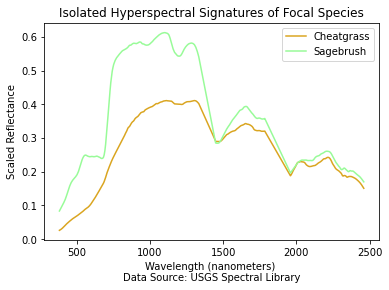

**************************************************
These spectral signatures are 86 percent similar.


In [23]:
# Plot spectral signatures from library
fig, (ax) = plt.subplots()
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_cheatgrass, label='Cheatgrass',
        color='goldenrod')
ax.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_sagebrush, label='Sagebrush',
       color='palegreen')
ax.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)
ax.set_title('Isolated Hyperspectral Signatures of Focal Species')

ax.set_ylabel('Scaled Reflectance')
plt.legend()
plt.savefig('sagebrush_cheatgrass_sl_signatures.png',
            transparent=True)
plt.show()
print('**************************************************')
print('These spectral signatures are',
      int(pearsonr(interp_res_cheatgrass,interp_res_sagebrush)[0]*100),
      'percent similar.')


# Create Objects for Endmember Extraction and Abundance Maps

In [9]:
ee = eea.NFINDR()
U=ee.extract(ONAQ_data['378000_4452000']['reflectance'],7,maxit=10,
               normalize=False,ATGP_init=True)

In [10]:
am = amap.FCLS() #define am object using the amap 
amaps = am.map(ONAQ_data['378000_4452000']['reflectance'],
               U,normalize=False) #create abundance maps for the HSI cubems

## Which Endmember is most likely Cheatgrass? Which one is sage?

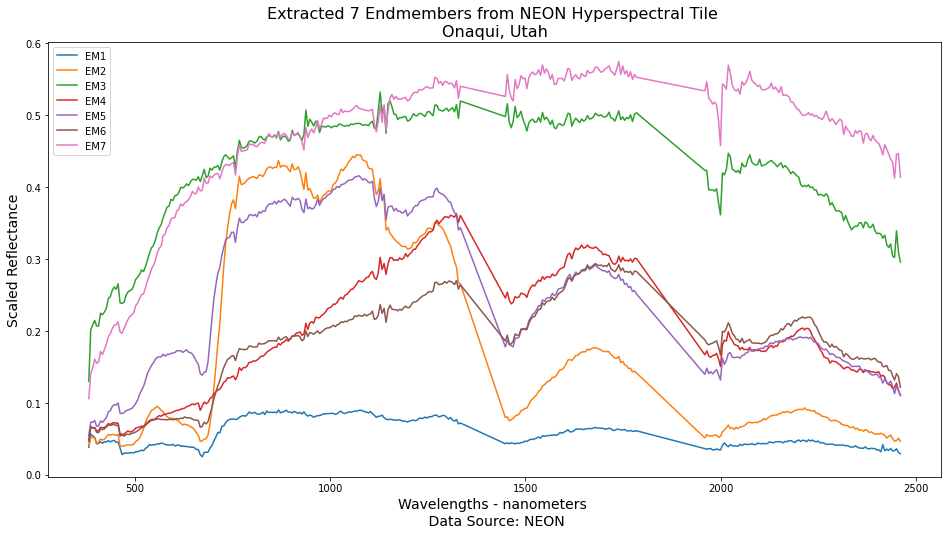

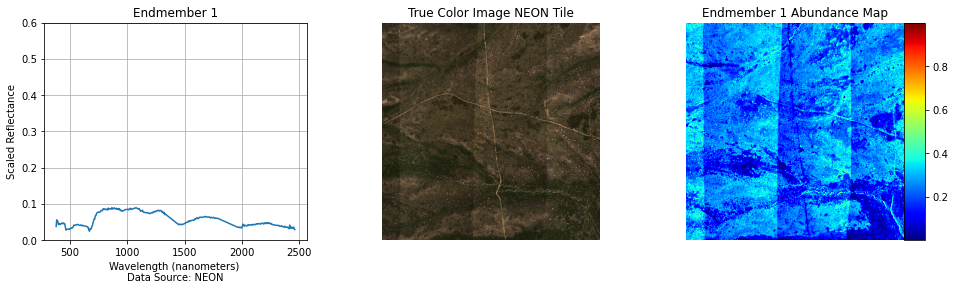

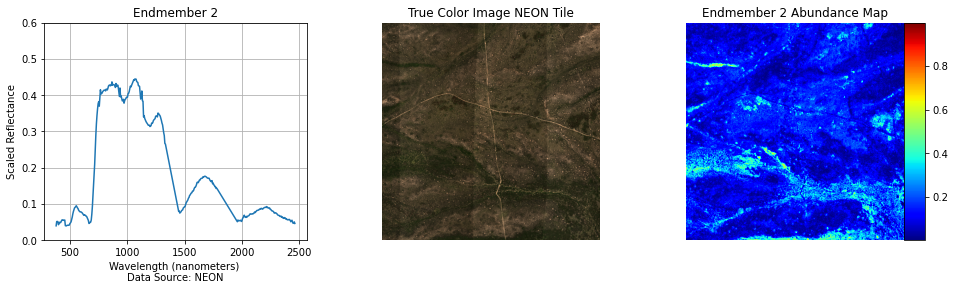

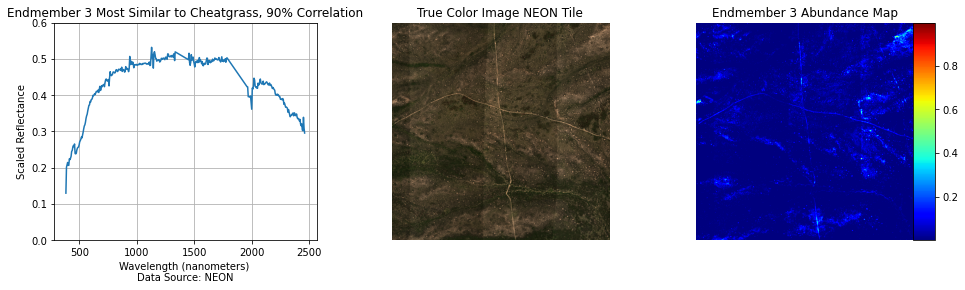

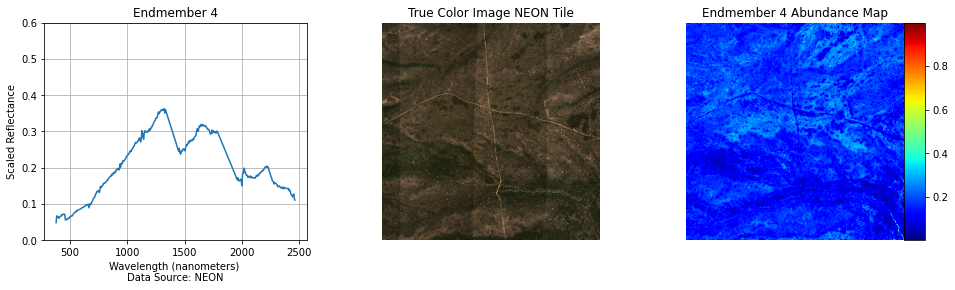

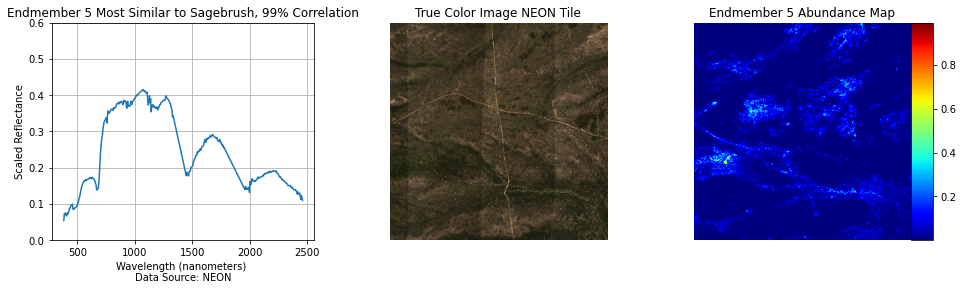

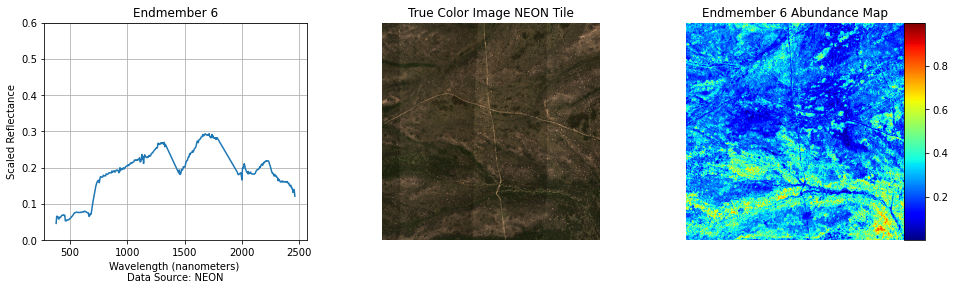

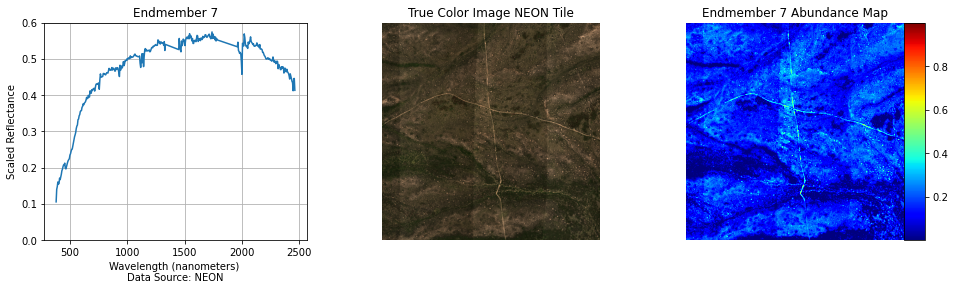

In [68]:
coefficient_sagebrush=[]
coefficient_cheatgrass=[]
for i in range(0,U.shape[0]):
    coefficient_sagebrush.append(pearsonr(
        interp_res_sagebrush,U[i])[0])
    coefficient_cheatgrass.append(pearsonr(
        interp_res_cheatgrass,U[i])[0])
closest_correl_sage=np.array(coefficient_sagebrush).max()
closest_correl_cheat=np.array(coefficient_cheatgrass).max()

plt.figure(figsize=(16,8))
plt.xlabel('Wavelengths - nanometers \n Data Source: NEON',
          fontsize=14)
plt.ylabel('Scaled Reflectance',
          fontsize=14)
n_em=0
for endmember in U:
    n_em+=1
    plt.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             endmember,
             label=f'EM{n_em}')   
plt.legend()
plt.title(f'Extracted {n_em} Endmembers from NEON Hyperspectral Tile \nOnaqui, Utah',
         fontsize=16)

plt.show()

n_em=0
for i,em in enumerate(U):
    n_em+=1
    fig = plt.figure(figsize=(16,4))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])     
    ax0 = plt.subplot(gs[0])
    p0 = ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'], em)
    if (pearsonr(interp_res_sagebrush,em)[0]) == closest_correl_sage:
        plt.title(
            f'Endmember {n_em} Most Similar to Sagebrush, {int(closest_correl_sage*100)}% Correlation')
    elif (pearsonr(interp_res_cheatgrass,em)[0]) == closest_correl_cheat:
        plt.title(
            f'Endmember {n_em} Most Similar to Cheatgrass, {int(closest_correl_cheat*100)}% Correlation')
    else:
        plt.title(f'Endmember {n_em}')
    ax0.grid(True)
    ax0.set_ylim(0,0.6)
    ax0.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: NEON',
               fontsize=10)
    ax0.set_ylabel('Scaled Reflectance',
               fontsize=10)

    ax1 = plt.subplot(gs[1])
    ax1.set_axis_off()
    im1 = ax1.imshow(bytescale(ONAQ_data['378000_4452000']['reflectance'][:,:,[54, 34, 22]]))
    plt.title('True Color Image NEON Tile')
    

    ax2 = plt.subplot(gs[2])
    im2 = ax2.imshow(amaps[:,:,i],cmap='jet')
    ax2.set_axis_off()
    plt.title(f'Endmember {n_em} Abundance Map')
    

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="10%", pad=0.001)

    plt.colorbar(im2, cax=cax)
    plt.show()


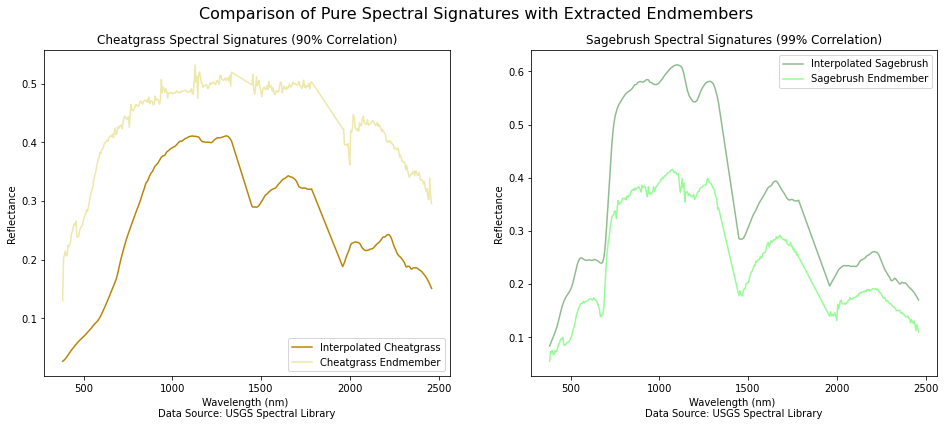

In [62]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,6))
plt.suptitle('Comparison of Pure Spectral Signatures with Extracted Endmembers',
            fontsize=16)
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_cheatgrass, label='Interpolated Cheatgrass',
        color='darkgoldenrod')
ax0.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             U[2],color='palegoldenrod',
             label='Cheatgrass Endmember')
ax0.set_xlabel('Wavelength (nm) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)
ax0.set_ylabel('Reflectance')
ax0.set_title('Cheatgrass Spectral Signatures (90% Correlation)')
ax0.legend()

ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
        interp_res_sagebrush, label='Interpolated Sagebrush',
       color='darkseagreen')
ax1.plot(ONAQ_data['378000_4452000']['metadata']['wavelength'],
             U[4],
             label='Sagebrush Endmember',
             color='palegreen')
ax1.set_xlabel('Wavelength (nm) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)

ax1.set_ylabel('Reflectance')
ax1.set_title('Sagebrush Spectral Signatures (99% Correlation)')
ax1.legend()
plt.show()